# Setup function

## This set of functions require the following inputs

<ul><li>a complete path to a pandas dataframe (file_path)</li><li>the separator used in the data file - preceded by a backslash (file_separator):</li><ul><li> comma - \\,</li><li>semi-colon - \\;</li><li>colon - \\:</li><li>etc.</li></ul><li>the target to predict (target_col) - the target is assumed to be numeric</li></ul>

<b>For Plotting</b> the script asks for 
<ul>
<li>plot titles for the axes</li>
<li>plot labels</li>
<li>Four(4) comma separated hex values for colors of the bars to be plotted</li> 
</ul>
For all the above, you can press enter to retain the default values (shown)
</br></br><br>
The main code of this notebook looks like this:

*train_it(file_path, target_col)*

but other parts of the function require the file separator (file_separator) as well, in order to properly read in the file.

<B>NOTE: I have attempted to make the code as easy to read as possible by naming the functions with descriptive titles.</B>

## Imports

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.linear_model
import math
import sys
from IPython.display import display, Javascript
import zipfile
from ast import If

In [55]:
# function to read in file based on type

def read_file(filepath, file_separator):
    
    if file_separator == None:
        file_type = input("Is your file fixed width(FW) or separated by a specific character(SC)? (FW/SC): ")
    else:
        file_type = 'SC'
    
    if file_type.upper() == 'FW':
        df = pd.read_fwf(filepath)
    else:
        df = pd.read_csv(filepath, sep=file_separator, engine='python')
        
    df_new = df.dropna()
    return df_new

In [56]:
def choose_target_column(df):
    from pandas.api.types import is_numeric_dtype

    numeric_cols = [col for col in df.columns if is_numeric_dtype(df[col])]
    
    if not numeric_cols:
        raise ValueError("No numeric columns found; please provide a dataset with at least one numeric target.")

    print("Available numeric columns (choose a target - if your target is NOT numeric, your dataset may not be suitable):")
    for idx, col in enumerate(numeric_cols, start=1):
        print(f"[{idx}] {col}")

    selection = input("Enter the number of the target column (default=1 - if your target is NOT numeric, your dataset may not be suitable): ").strip()
    if selection == "":
        selection = 1
    try:
        selection = int(selection)
        target = numeric_cols[selection - 1]
    except (ValueError, IndexError):
        print("Invalid selection; defaulting to the first numeric column.")
        target = numeric_cols[0]

    return target

In [57]:
# Helper function to check if a file is a ZIP file

def is_zip_file(filename):
    return zipfile.is_zipfile(filename)

## Get user input and Call read function

In [58]:
file_path = input("Full path to dataframe (zip files are not supported): ")
file_separator = input("Separator used in dataframe (i.e., '\\t' for tab, '\,' for comma, etc., without the quotes: ")

if is_zip_file(file_path):
    print("ZIP files are not supported. Please provide a direct path to a supported filetype.")
    exit()
    
try:
    dataframe = read_file(file_path,file_separator)
    target_col = choose_target_column(dataframe)
    # Split out features/target for convenience
    features = dataframe.drop(columns=[target_col])
    target_values = dataframe[target_col]
except:
    print("Error reading file. Please check the file path and separator. Please rerun this notebook and provide a link to a supported filetype.")
    exit()


Available numeric columns (choose a target - if your target is NOT numeric, your dataset may not be suitable):
[1] Marital status
[2] Application mode
[3] Application order
[4] Course
[5] AttendanceTime
[6] Previous qualification
[7] Previous qualification (grade)
[8] Nacionality
[9] Mother's qualification
[10] Father's qualification
[11] Mother's occupation
[12] Father's occupation
[13] Admission grade
[14] Displaced
[15] Educational special needs
[16] Debtor
[17] Tuition fees up to date
[18] Gender
[19] Scholarship holder
[20] Age at enrollment
[21] International
[22] Curricular units 1st sem (credited)
[23] Curricular units 1st sem (enrolled)
[24] Curricular units 1st sem (evaluations)
[25] Curricular units 1st sem (approved)
[26] Curricular units 1st sem (grade)
[27] Curricular units 1st sem (without evaluations)
[28] Curricular units 2nd sem (credited)
[29] Curricular units 2nd sem (enrolled)
[30] Curricular units 2nd sem (evaluations)
[31] Curricular units 2nd sem (approved)
[32]

# Define other functions

## Plot and Compare function

In [59]:
def plot_to_compare(model_name1, score1, mse1, model_name2, score2, mse2, model_name3, score3, mse3, model_name4, score4, mse4):
    
    # Define axis titles and labels
    Axis1Title = input("Enter title for MSE plot: (Default: 'Model Mean Squared Error (LOWER IS BETTER)'): ")
    if Axis1Title.strip() == "":
        Axis1Title = "Model Mean Squared Error (LOWER IS BETTER)"
    Axis2Title = input("Enter title for Accuracy plot: (Default: 'Model Accuracy (HIGHER IS BETTER)'): ")
    if Axis2Title.strip() == "":
        Axis2Title = "Model Accuracy (HIGHER IS BETTER)"
    Axis1_YLabel = input("Enter label for MSE Y-axis (Default: 'Mean Squared Error'): ")
    if Axis1_YLabel.strip() == "":
        Axis1_YLabel = "Mean Squared Error"
    Axis2_YLabel = input("Enter label for Accuracy Y-axis (Default: 'Accuracy'): ")
    if Axis2_YLabel.strip() == "":
        Axis2_YLabel = "Accuracy"
        
    # Define color palette
    colorpalette = input("Enter 4 hex color codes separated by commas for the bars (Default: '#4E79A7 - skyblue,#F28E2B - orange,#E15759 - red,#76B7B2 - teal'): ")   
    if colorpalette.strip() == "":
        colorpalette = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']
    else:
        colorpalette = [color.strip() for color in colorpalette.split(",")]
    
    print(f"\n\n\033[1mThis can be plotted with the following results:\033[0m\n")
    
    models = [model_name1, model_name2, model_name3, model_name4]
    scores = [score1, score2, score3, score4]
    mse_scores = [mse1, mse2, mse3, mse4]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    
    bars1 = ax1.bar(models, mse_scores, color=colorpalette)
    for bar, score in zip(bars1, mse_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.4f}', ha='center', va='bottom', fontsize=8)
    ax1.set_title(Axis1Title)
    ax1.set_ylabel(Axis1_YLabel)
    ax1.set_ylim(0, max(mse_scores) * 1.1)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    bars2 = ax2.bar(models, scores, color=colorpalette)
    for bar, score in zip(bars2, scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.4f}', ha='center', va='bottom', fontsize=8)
    ax2.set_title(Axis2Title)
    ax2.set_ylabel(Axis2_YLabel)
    ax2.set_ylim(0, max(scores) * 1.1)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    for ax in (ax1, ax2):
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=15)

    plt.tight_layout()
    plt.show()
    plt.close()

    return

## train and evaluate function

In [60]:
def train_and_evaluate_model(model_type, model_name_str, X_train, X_test, y_train, y_test):
    
    from sklearn.metrics import mean_squared_error

    model = model_type
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Model:\033[1m{model_name_str:<24}\033[0m\tAccuracy Score:\t\033[1m{score:.4f}\033[0m\tMSE Score:\t\033[1m{mse:.4f}\033[0m")
    
    return model_name_str, score, mse

## train it function

In [61]:
def train_it(data, target):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression, Ridge
    from sklearn.svm import LinearSVC

    y = data[target].copy()
    X = data.drop(columns=[target])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Call the train and evaluate model function for each model
    
    iters = 1000
    penalty = 'l2'
    estimators = 7
    depth = 7
    
    model_name1, score1, mse1 = train_and_evaluate_model(LogisticRegression(penalty=penalty, max_iter=iters), 'Logistic Regression', X_train, X_test, y_train, y_test)
    model_name2, score2, mse2 = train_and_evaluate_model(LinearSVC(penalty=penalty, max_iter=iters), 'Linear SVC', X_train, X_test, y_train, y_test)
    model_name3, score3, mse3 = train_and_evaluate_model(Ridge(alpha=1.0, max_iter=iters), 'Ridge', X_train, X_test, y_train, y_test)
    model_name4, score4, mse4 = train_and_evaluate_model(RandomForestClassifier(n_estimators=estimators, max_depth=depth), 'Random Forest Classifier', X_train, X_test, y_train, y_test)
    # Call the plot function with the results from the train and evaluate function

    plot_to_compare(model_name1, score1, mse1, model_name2, score2, mse2, model_name3, score3, mse3, model_name4, score4, mse4)

    return



# Call Main function

## call train function

c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model:Logistic Regression     	Accuracy Score:	0.7259	MSE Score:	0.5203
Model:Linear SVC              	Accuracy Score:	0.7545	MSE Score:	0.4827
Model:Ridge                   	Accuracy Score:	0.2789	MSE Score:	0.3568
Model:Random Forest Classifier	Accuracy Score:	0.7440	MSE Score:	0.4706


This can be plotted with the following results:



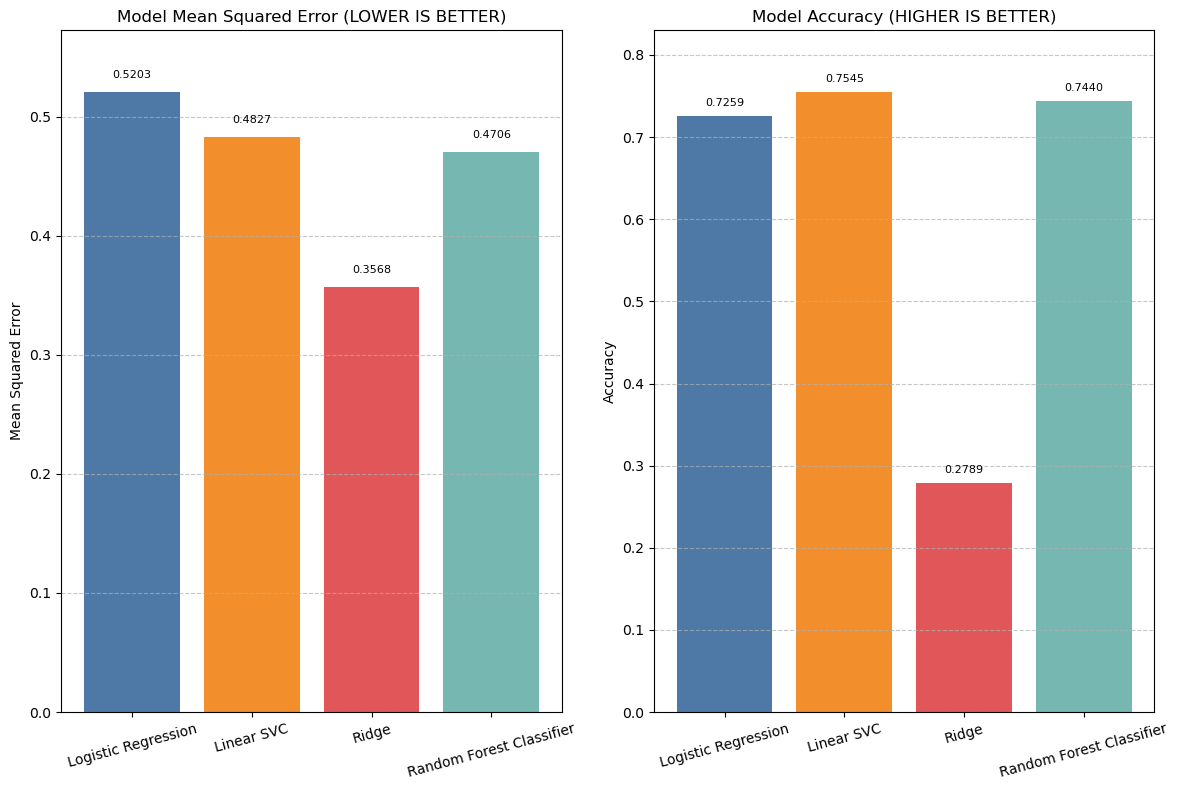

In [62]:
train_it(dataframe, target_col)